# A. Loading the required libraries 
- importing standard python libraries 
- importing self written utils functions 
- declaring paths for finding data and saving text and images 

In [128]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline


#Libraries to make/construct the pdf for the final overview
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

# System libraries
import warnings
import sys
import os
import inspect
from collections import Counter
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import utils library with custom functions
# Annotation: If there is a change in the utils function collect this window has to be executed twice 
# In order to get the utils functions loaded to the kernel to make the updated versions available for the notebook 
from utils_finance import *
import utils_finance
import importlib
importlib.reload(utils_finance)

# This library is for an offline translater which is required for the pretrained classifier model
# The model was trained for english language but the script is made for german financial data 
from translate import Translator

# This downloads a pretrained large language machine learning model from hugging face library 
# The download process will be visible below 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# This download will use the marianMTmodel for translation
from transformers import MarianMTModel, MarianTokenizer



In [129]:
# Path to the neighboring 'plots' folder in the local repository
plots_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'plots'))
print(plots_path)


# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
print(data_path)

# Path to the neighboring 'reports' folder in the local repository where the conclusive report will be saved as a pdf 
report_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports'))
print(report_path)


/Users/tillo/Repositoriums/FinanceGrouper/plots
/Users/tillo/Repositoriums/FinanceGrouper/data
/Users/tillo/Repositoriums/FinanceGrouper/reports


# B. Data management
+ finding the data 
+ loading all available years  
+ concatenate all years of the data
+ saving the all years df  

In [130]:
# Retrieving data

# CSV files from DKB have a cryptic header; skip the first rows to make it readable
headerSize = 4

# List to store each DataFrame for later concatenation
dataframes = []

# Iterate through all files in the Data directory
for filename in os.listdir(data_path):
    # Skip "Data_All_Years.csv" if it already exists
    if filename == "Data_All_Years.csv":
        continue
    # Skip the training data for the ML model
    if filename == "Training_Data.csv":
        continue
    # Skip the finalized data from the runs before
    if filename == "Data_Treated.csv":
        continue
     
    # Check if the file is a .csv file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(data_path, filename)

        # Extract the last 4 digits of the filename (assuming they represent the year)
        last_four_digits = filename[-8:-4]
        
        # Make the year variable
        year = int(last_four_digits)

        # Read the .csv file into a DataFrame
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path, sep=',', skiprows=headerSize, header=0, encoding='utf-8-sig')

        # Save the DataFrame under a dynamic name
        globals()[f'df_{last_four_digits}'] = df

        # Append the DataFrame to the list for concatenation
        dataframes.append(df)

        # Display the shape and column names of the DataFrame
        print('Shape:', df.shape)
        print('Column names:', df.columns)

# Concatenate all data to a single DataFrame
df_all_years = pd.concat(dataframes, ignore_index=True)

# Save the concatenated DataFrame to "Data_All_Years.csv"
output_path = os.path.join(data_path, "Data_All_Years.csv")
df_all_years.to_csv(output_path, index=False, sep=';')
print(f"Concatenated DataFrame saved to: {output_path}")


df = df_all_years

Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_dummy_2024.csv
Shape: (551, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_dummy_2023.csv
Shape: (533, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transactions_dummy_2022.csv
Shape: (437, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBA

In [131]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 1521 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status Zahlungspflichtige*r  \
0      25.10.24     25.10.24  Gebucht               ISSUER   
1      25.10.24     25.10.24  Gebucht        Max Musterman   
2      24.10.24     24.10.24  Gebucht               ISSUER   
3      23.10.24     23.10.24  Gebucht               ISSUER   
4      23.10.24     23.10.24  Gebucht               ISSUER   

            Zahlungsempfänger*in  \
0    PAYPAL..EBAY.DE/35314369001   
1  AMAZON PAYMENTS EUROPE S.C.A.   
2      SPORTPARK.LEIPZIG/LEIPZIG   
3                         Konsum   
4                  Deutsche Bahn   

                                    Verwendungszweck Umsatztyp  \
0                             VISA Debitkartenumsatz   Ausgang   
1  304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH   Ausgang   
2                             VISA Debitkartenumsatz   Ausgang   
3                             VISA Debitka

# C. First cleaning of data set
+ deleting empty rows and columns 
+ fixing Euro ',' and '.' problem in numbers 
+ changing type of columns to numerical (floats) and types (object)
+ filter all entrances which have very long empty entrys and make them to only one ' '

In [132]:
### Deleting empty columns and rows for each df before saving it in a global variable 
# Identify columns that contain only NaN values
nan_columns = df.columns[df.isna().all()].tolist()    
# Drop the columns with only NaN values
df.drop(columns=nan_columns, inplace=True)
# Delete all rows that are completely empty (i.e., contain only NaN values)
empty_rows = df[df.isna().all(axis=1)].index
df.drop(index=empty_rows, inplace=True)

Set type of data of the columns 

In [133]:
# Fix US / EU decimal-point/comma
df['Betrag (€)'] = df['Betrag (€)'].str.replace('.','')
df['Betrag (€)'] = df['Betrag (€)'].str.replace(',','.')


In [134]:

# All columns will be set accordingly as dtype to what sort of stuff they contain 
df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], format='%d.%m.%y', errors='coerce')
df['Wertstellung'] = pd.to_datetime(df['Wertstellung'], format='%d.%m.%y', errors='coerce')
df['Status'] = df['Status'].astype('category')

# Make sure euro is set to float
df['Betrag (€)'] = df['Betrag (€)'].astype(float)

# List of columns which should be set and transformed to strings 
string_columns = [
    'Zahlungspflichtige*r',
    'Zahlungsempfänger*in',
    'Verwendungszweck',
    'IBAN',
    'Gläubiger-ID',
    'Mandatsreferenz',
    'Kundenreferenz'
]

for col in string_columns:
    # Zwingend sicherstellen, dass alle Werte entweder str oder pd.NA sind
    df[col] = df[col].apply(lambda x: x if isinstance(x, str) else pd.NA)
    # Convert the column to typ 'string'
    df[col] = df[col].astype('string')

#Check if it worked 
inspect_data(df)


🚀 Basic Data Overview
🗂 Shape of the DataFrame: 1521 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status Zahlungspflichtige*r  \
0    2024-10-25   2024-10-25  Gebucht               ISSUER   
1    2024-10-25   2024-10-25  Gebucht        Max Musterman   
2    2024-10-24   2024-10-24  Gebucht               ISSUER   
3    2024-10-23   2024-10-23  Gebucht               ISSUER   
4    2024-10-23   2024-10-23  Gebucht               ISSUER   

            Zahlungsempfänger*in  \
0    PAYPAL..EBAY.DE/35314369001   
1  AMAZON PAYMENTS EUROPE S.C.A.   
2      SPORTPARK.LEIPZIG/LEIPZIG   
3                         Konsum   
4                  Deutsche Bahn   

                                    Verwendungszweck Umsatztyp  \
0                             VISA Debitkartenumsatz   Ausgang   
1  304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH   Ausgang   
2                             VISA Debitkartenumsatz   Ausgang   
3                             VISA Debitka

In [135]:
# Function to replace multiple spaces and new lines with a single space
df = reduce_multiple_spaces_and_newlines(df)

# D. Categorizing 
+ translation of the "verwendungszweck" column into english due to pre trained model 
+ categorizing of the incomes and expanses 
+ making separate category column 
+ shorting strings in df which are too long (informations are not needed anymore)

## D. 1 Translate

In [136]:
# This code translates the "Verwendungszweck" (Purpose) column into English for various descriptions 
# of account transactions. 
# This is necessary because the pre-trained financial organizer operates in English.
# If the account transactions are already recorded in English, this function becomes redundant 
# and can be commented out.

# Load the model and tokenizer for German → English translation
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_text(text):
    """
    Translates the given text from German to English using MarianMT.

    Parameters:
        text (str): The text to translate.

    Returns:
        str: Translated text or an error message if translation fails.
    """
    try:
        # Tokenize the text and perform translation
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        translated = model.generate(**inputs)
        # Decode the translated output
        return tokenizer.decode(translated[0], skip_special_tokens=True)
    except Exception as e:
        return f"Error during translation: {e}"

# Count the frequency of values in the "Verwendungszweck" column
value_counts = Counter(df["Verwendungszweck"])

# Print only the values that appear more than once
print("Values appearing more than once in 'Verwendungszweck':")
for value, count in value_counts.items():
    if count > 1:
        print(f"{value}: {count} times")

# Extract unique values from the "Verwendungszweck" column
unique_values = df["Verwendungszweck"].unique()

# Translate unique values and store them in a dictionary
translations = {value: translate_text(value) for value in unique_values}

# Add the translated values as a new column in the DataFrame
df["Description_English"] = df["Verwendungszweck"].map(translations)

# Print the number of unique values with duplicates
duplicate_count = sum(1 for count in value_counts.values() if count > 1)
print(f"Number of unique values with duplicates in 'Verwendungszweck': {duplicate_count}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Values appearing more than once in 'Verwendungszweck':
VISA Debitkartenumsatz: 1138 times
21,00 Euro Fordermitgliedschaft Mitgliedsnummer 8001671084 Vielen Dank: 2 times
Miete Tillo: 34 times
Mitgliedsbeitrag Wikimedia Deutschland - Info: neue IBAN bei uns: 3 times
VISA Debitkartenumsatz in Fremdwährung / Ursprungsbetrag in Fremdwährung 8,00 ILS / Umrechnungsrate: 1 Euro=3,96039600 ILS: 2 times
100014235755: 3 times
Gemüsekiste: 11 times
Mitgliedsbeitrag Wikimedia Deutschland: 3 times
Rettungsschirm: 2 times
Ruecklagen nr 2: 11 times
Ruecklagen: 11 times
Gemuesekiste: 10 times
4930000007845432 15.28 TIL RALKA DKB INTERNET BANKING: 5 times
Girokartenumsatz: 4 times
<NA>: 2 times
Number of unique values with duplicates in 'Verwendungszweck': 15


In [137]:
df.head()

,Buchungsdatum,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Description_English
0,2024-10-25,2024-10-25,Gebucht,ISSUER,PAYPAL..EBAY.DE/35314369001,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-50.39,<NA>,<NA>,464296283258250,VISA Debit card turnover
1,2024-10-25,2024-10-25,Gebucht,Max Musterman,AMAZON PAYMENTS EUROPE S.C.A.,304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH,Ausgang,DE54703155438938518304,-9.91,DE94ZZZ00000561653,5Uc8oykgYwBt8lQ.nzbZJ:Y6rzPYO2,600VIXZVWCAJCOLH,304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH
2,2024-10-24,2024-10-24,Gebucht,ISSUER,SPORTPARK.LEIPZIG/LEIPZIG,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-12.00,<NA>,<NA>,484297590357671,VISA Debit card turnover
3,2024-10-23,2024-10-23,Gebucht,ISSUER,Konsum,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-18.57,<NA>,<NA>,484296486826357,VISA Debit card turnover
4,2024-10-23,2024-10-23,Gebucht,ISSUER,Deutsche Bahn,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-22.05,<NA>,<NA>,304294205547754,VISA Debit card turnover


## D. 2 Define categories & load model

In [138]:
# Load FinBERT-tone model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# The categories with their corresponding key words are writen down and saved in the utils_finance document of 
# the repository. See src folder -> utils_finance.py 
from utils_finance import categories

# Helper function to categorize a transaction based on FinBERT predictions
def categorize_transaction(description):
    # Apply the FinBERT-tone model
    results = classifier(description)
    
    # Map FinBERT's predictions to categories (custom logic based on labels and description)
    category_scores = {cat: 0 for cat in categories.keys()}
    for cat, keywords in categories.items():
        if any(keyword.lower() in description.lower() for keyword in keywords):
            category_scores[cat] += 1
    
    # Return the best matching category or Miscellaneous if no match found
    best_category = max(category_scores, key=category_scores.get)
    return best_category if category_scores[best_category] > 0 else "Miscellaneous"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cpu


## D. 3 Apply categorizer and clean up df 

In [139]:
# Ensure that the 'Verwendungszweck' column only contains strings
df["Verwendungszweck"] = df["Verwendungszweck"].astype(str)
# Optionally, you can replace any "None" or other non-string values with an empty string or some other placeholder
df["Verwendungszweck"] = df["Verwendungszweck"].fillna('')

# Apply categorization to the DataFrame based on various columns
df["Category1"] = df["Description_English"].apply(categorize_transaction)
df["Category2"] = df["Zahlungspflichtige*r"].apply(categorize_transaction)
df["Category3"] = df["Zahlungsempfänger*in"].apply(categorize_transaction)
df["Category4"] = df["Verwendungszweck"].apply(categorize_transaction)

# Determine the final category based on the four intermediate categories
df['Category'] = df.apply(determine_final_category, axis=1)

# Remove the intermediate category columns to clean up the DataFrame
df = df.drop(columns=['Category1', 'Category2', 'Category3', 'Category4'])

In [140]:
# Display the first 20 rows of the updated DataFrame
df.head()

,Buchungsdatum,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Description_English,Category
0,2024-10-25,2024-10-25,Gebucht,ISSUER,PAYPAL..EBAY.DE/35314369001,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-50.39,<NA>,<NA>,464296283258250,VISA Debit card turnover,"Saving, Investing and Debt Payments"
1,2024-10-25,2024-10-25,Gebucht,Max Musterman,AMAZON PAYMENTS EUROPE S.C.A.,304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH,Ausgang,DE54703155438938518304,-9.91,DE94ZZZ00000561653,5Uc8oykgYwBt8lQ.nzbZJ:Y6rzPYO2,600VIXZVWCAJCOLH,304-5350210-5156366 AMZN Mktp DE 600VIXZVWCAJCOLH,Online Shopping
2,2024-10-24,2024-10-24,Gebucht,ISSUER,SPORTPARK.LEIPZIG/LEIPZIG,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-12.00,<NA>,<NA>,484297590357671,VISA Debit card turnover,Personal Spending
3,2024-10-23,2024-10-23,Gebucht,ISSUER,Konsum,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-18.57,<NA>,<NA>,484296486826357,VISA Debit card turnover,Supermarket and Drogerie
4,2024-10-23,2024-10-23,Gebucht,ISSUER,Deutsche Bahn,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-22.05,<NA>,<NA>,304294205547754,VISA Debit card turnover,Transportation


In [141]:
# Function to shorten all strings in the df to below 30 letters
# Default is set to 30 in the function, if none is given 
df = truncate_strings_in_dataframe(df, max_length=30)


In [142]:
inspect_data(df)
df.head()

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 1521 rows, 14 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status Zahlungspflichtige*r  \
0    2024-10-25   2024-10-25  Gebucht               ISSUER   
1    2024-10-25   2024-10-25  Gebucht        Max Musterman   
2    2024-10-24   2024-10-24  Gebucht               ISSUER   
3    2024-10-23   2024-10-23  Gebucht               ISSUER   
4    2024-10-23   2024-10-23  Gebucht               ISSUER   

            Zahlungsempfänger*in                Verwendungszweck Umsatztyp  \
0    PAYPAL..EBAY.DE/35314369001          VISA Debitkartenumsatz   Ausgang   
1  AMAZON PAYMENTS EUROPE S.C.A.  304-5350210-5156366 AMZN Mktp    Ausgang   
2      SPORTPARK.LEIPZIG/LEIPZIG          VISA Debitkartenumsatz   Ausgang   
3                         Konsum          VISA Debitkartenumsatz   Ausgang   
4                  Deutsche Bahn          VISA Debitkartenumsatz   Ausgang   

                     IBAN  Betrag (€)        Gläubiger

,Buchungsdatum,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Description_English,Category
0,2024-10-25,2024-10-25,Gebucht,ISSUER,PAYPAL..EBAY.DE/35314369001,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-50.39,<NA>,<NA>,464296283258250,VISA Debit card turnover,"Saving, Investing and Debt Pay"
1,2024-10-25,2024-10-25,Gebucht,Max Musterman,AMAZON PAYMENTS EUROPE S.C.A.,304-5350210-5156366 AMZN Mktp,Ausgang,DE54703155438938518304,-9.91,DE94ZZZ00000561653,5Uc8oykgYwBt8lQ.nzbZJ:Y6rzPYO2,600VIXZVWCAJCOLH,304-5350210-5156366 AMZN Mktp,Online Shopping
2,2024-10-24,2024-10-24,Gebucht,ISSUER,SPORTPARK.LEIPZIG/LEIPZIG,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-12.00,<NA>,<NA>,484297590357671,VISA Debit card turnover,Personal Spending
3,2024-10-23,2024-10-23,Gebucht,ISSUER,Konsum,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-18.57,<NA>,<NA>,484296486826357,VISA Debit card turnover,Supermarket and Drogerie
4,2024-10-23,2024-10-23,Gebucht,ISSUER,Deutsche Bahn,VISA Debitkartenumsatz,Ausgang,DE27553680563705759037,-22.05,<NA>,<NA>,304294205547754,VISA Debit card turnover,Transportation


# E. Analysis of the financial data

## E. 1 Basic analysis of the data 
+ Calculate total income and expenses.
+ Determine monthly savings (income minus expenses).
+ Identify the largest expenses and sources of income.

In [143]:
# Performs basic financial analysis including total income, expenses, and largest transactions
text_1 = basic_analysis(df)
print(text_1)

Total Income: €71844.30
Total Expenses: €-69382.54

Monthly Savings:
month
2022-01    1406.19
2022-02     605.79
2022-03     226.67
2022-04    -730.55
2022-05   -1215.11
2022-06    -135.91
2022-07    -753.87
2022-08     801.41
2022-09     -50.73
2022-10    -119.88
2022-11    1730.14
2022-12     782.42
2023-01    -333.00
2023-02     -62.90
2023-03   -1029.69
2023-04   -1349.30
2023-05    -439.47
2023-06     141.61
2023-07     649.91
2023-08    1096.59
2023-09    1115.11
2023-10     519.35
2023-11     195.81
2023-12     655.49
2024-01       4.51
2024-02     730.15
2024-03      22.56
2024-04     345.81
2024-05     261.90
2024-06    -237.64
2024-07    -371.27
2024-08    -201.87
2024-09    -161.68
2024-10   -1636.79
Freq: M

Largest Expense:
Buchungsdatum Zahlungsempfänger*in  Betrag (€)
   2022-08-17             MITOS AE     -1660.0

Largest Income:
Buchungsdatum Zahlungspflichtige*r  Betrag (€)
   2024-05-31       Random-IT GmbH     2548.33

Most frequent income source: Arbeitgeber XYZ
Mo

## E. 2 Income and Expense Categorization
+ Categorize transactions by Umsatztyp (e.g., groceries, rent, salary) to provide a breakdown of expenses and income per category. 
+ This helps understand which categories contribute the most to expenses and income.

In [144]:
# Group by 'Umsatztyp' and calculate total income and expenses per category
text_2 = analyze_by_category(df)
print(text_2)

Total by Category:
Umsatztyp
Ausgang   -69382.54
Eingang    71844.30
 



## E. 3 Income vs Expense Trend Over Time 
+ Create a time series analysis to visualize income and expenses trends over time (e.g., monthly, quarterly).


In [145]:
# Creates a time series analysis of income and expenses over time
income_expense_trend(df, plots_path)


'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_expense_trend.png'

## E. 4 Average Monthly Income/Expense
Calculate the average monthly income and expense to get an overall view of typical monthly financial activity.

In [146]:
# Calculates average monthly income and expenses.
text3 = average_monthly_stats(df)
print(text3)

Monthly income VS expanse: 
The average monthly income is €2177.10, and the average monthly expenses are €-2040.66. 
 



## E. 5 Recurring Transactions Detection
Identify recurring transactions such as regular payments (e.g., rent, subscriptions) or income (e.g., salary) based on similar amounts and descriptions.

In [147]:
# Identifies recurring transactions based on recipient and amount
recurring_summary = detect_recurring_transactions(df)
# Function which extracts the text info from the pandas df for the summary pdf later on
text4 = text_recurring_transactions(recurring_summary)
# Call the function and display the first few rows of the recurring transactions
recurring_summary.head()


,Zahlungsempfänger*in,Betrag (€),Count
78,Telefonica Germany G Georg-Bra,-9.99,23
16,Boulderhalle Leipzig Gm,-8.00,13
45,Max Musterman,-447.00,12
46,Max Musterman,-402.00,11
47,Max Musterman,-200.00,11


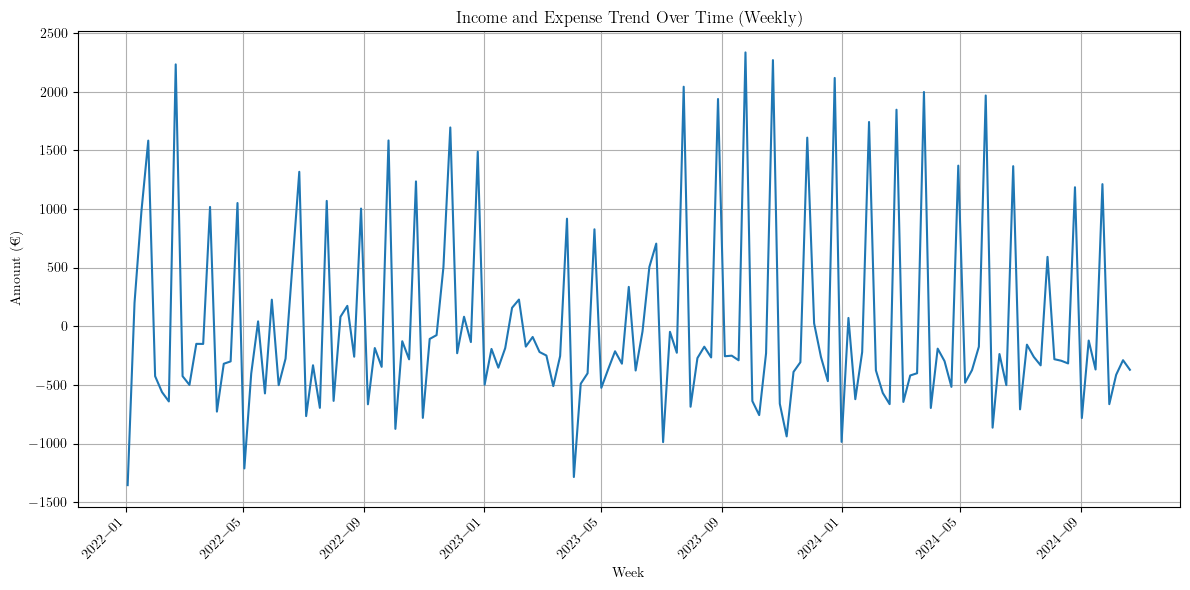

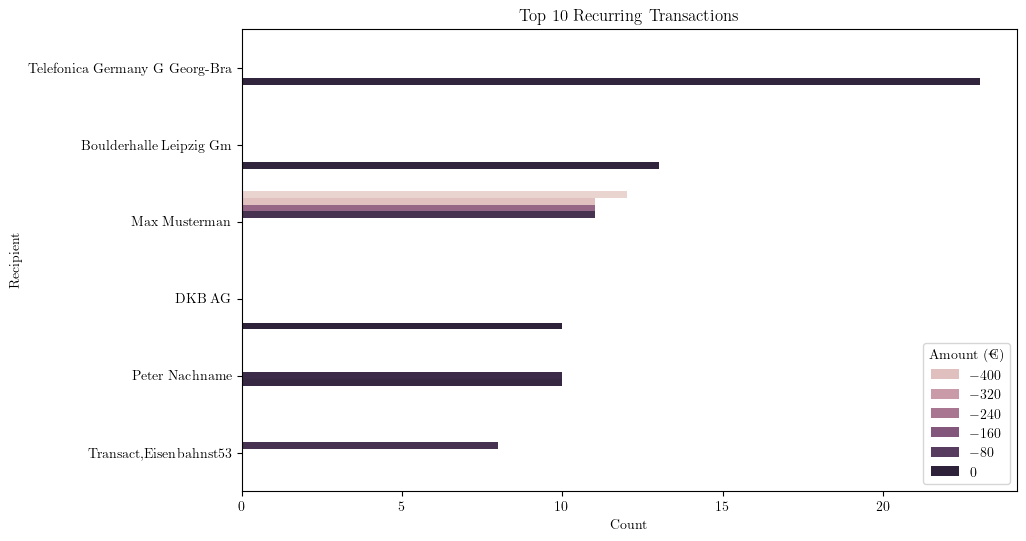

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_recurring_summary.png'

In [148]:
# Visualizes the top recurring transactions in a bar plot
plot_recurring_summary(recurring_summary, plots_path)

## E. 6 Monthly Expense to Income Ratio
Calculate the expense-to-income ratio to determine how much of your income is spent each month.

In [149]:
# Calculates the expense-to-income ratio per month
text5 = expense_income_ratio(df)


## E. 7 Expense Breakdown by Vendor/Recipient
Provide a breakdown of total expenses by Zahlungsempfänger*in to identify who you are spending the most money on.

In [150]:
# Provides a breakdown of expenses by recipient
text6 = expenses_by_recipient(df)


Expenses by Recipient:
Zahlungsempfänger*in
Max Musterman                    -13443.00
MICHAEL Sternedy                  -4050.00
DKB VISACARD                      -3104.69
3273 Konsum Rosa Luxemb           -2768.76
PAYPAL .Sofie.Raiter              -1925.00
Transact GA 7724                  -1750.00
MITOS AE                          -1660.00
Transact,Eisenbahnst53            -1550.00
IBERIA 0751415725228              -1093.26
DB Vertrieb GmbH                  -1042.55
REWE Christopher S                -1007.26
Transact,GA 7724                   -950.00
Euronet ATM                        -790.00
AMAZON EU S.A R.L., NIEDERLASS     -727.99
Transact Eisenbahnst53             -700.00
Netto Marken-Discount              -694.87
Club Nautique GmbH                 -640.00
PAYPAL .DBVERTRIEBG A-             -611.20
Stadt- und KSK Leipzig             -600.00
AMAZON PAYMENTS EUROPE S.C.A.      -569.03
Peter Nachname                     -493.00
MARTIN ZITZMANN                    -490.00
Konsum   

## E. 8 Outlier Detection
Identify unusually large transactions by detecting outliers (e.g., large expenses that are significantly different from the average).

In [151]:
# Identifies unusual transactions using standard deviation
text7 = detect_outliers(df)


Outliers:
Buchungsdatum  Betrag (€)               Verwendungszweck
   2024-09-27     1296.30 074D221746/07501/7004 01.09.24
   2024-08-29      993.83 074D221746/07501/7004 08.08.24
   2024-07-30     1296.30 074D221746/07501/7002 01.07.24
   2024-06-28     1079.20                 Gehalt 06/2024
   2024-05-31     2548.33                 Gehalt 05/2024
   2024-04-30     2548.33                 Gehalt 04/2024
   2024-03-28     2329.69                 Gehalt 03/2024
   2024-02-29     2548.33                 Gehalt 02/2024
   2024-01-30     2548.33                 Gehalt 01/2024
   2023-12-28     2548.33                 Gehalt 12/2023
   2023-11-29     2548.33                 Gehalt 11/2023
   2023-10-26     2548.33                 Gehalt 10/2023
   2023-09-28     2548.33                 Gehalt 09/2023
   2023-08-30     2548.33                 Gehalt 08/2023
   2023-07-27     2548.33                 Gehalt 07/2023
   2023-05-30      999.00 074D221746/07501/7002 01.05.23
   2023-04-27      9

## E. 9 Savings Percentage
Calculate the percentage of income saved each month.

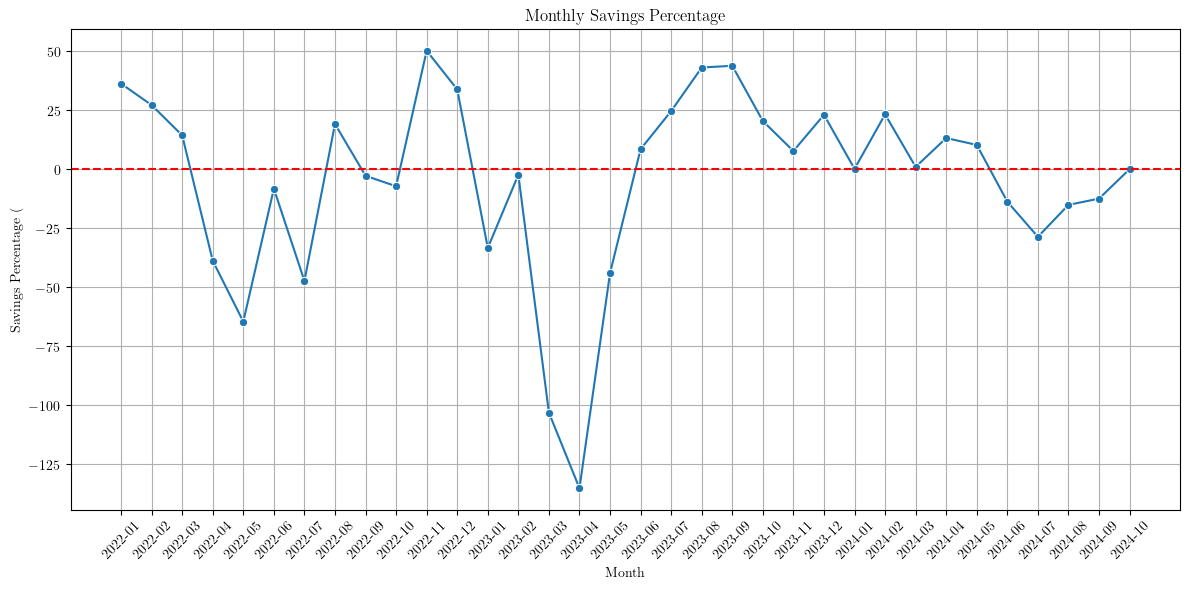

'/Users/tillo/Repositoriums/FinanceGrouper/plots/savings_percentage.png'

In [152]:
# Calculates and visualizes monthly savings percentage
savings_percentage(df, plots_path)

## E. 10 Cash Flow Stability
Calculate cash flow volatility to measure the consistency of your monthly income and expenses.

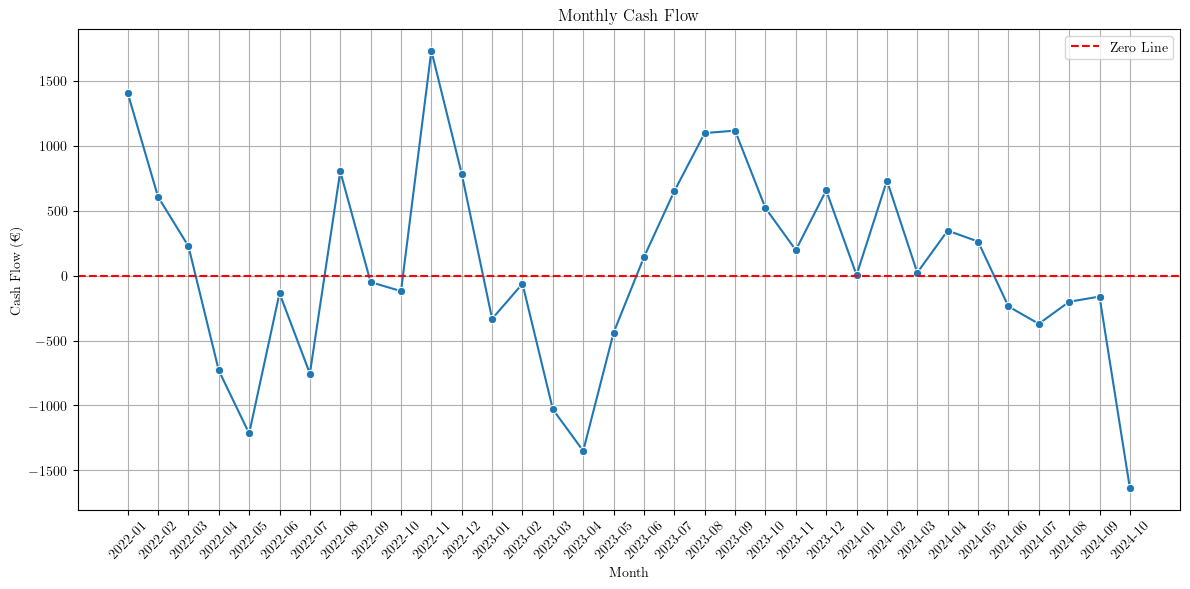

'/Users/tillo/Repositoriums/FinanceGrouper/plots/cash_flow_volatility.png'

In [153]:
# Calculates and visualizes cash flow stability over time
cash_flow_volatility(df, plots_path)

## E. 11 Income Sources Breakdown
Break down the sources of income (e.g., salary, refunds) by Zahlungspflichtige*r and analyze which contribute the most.

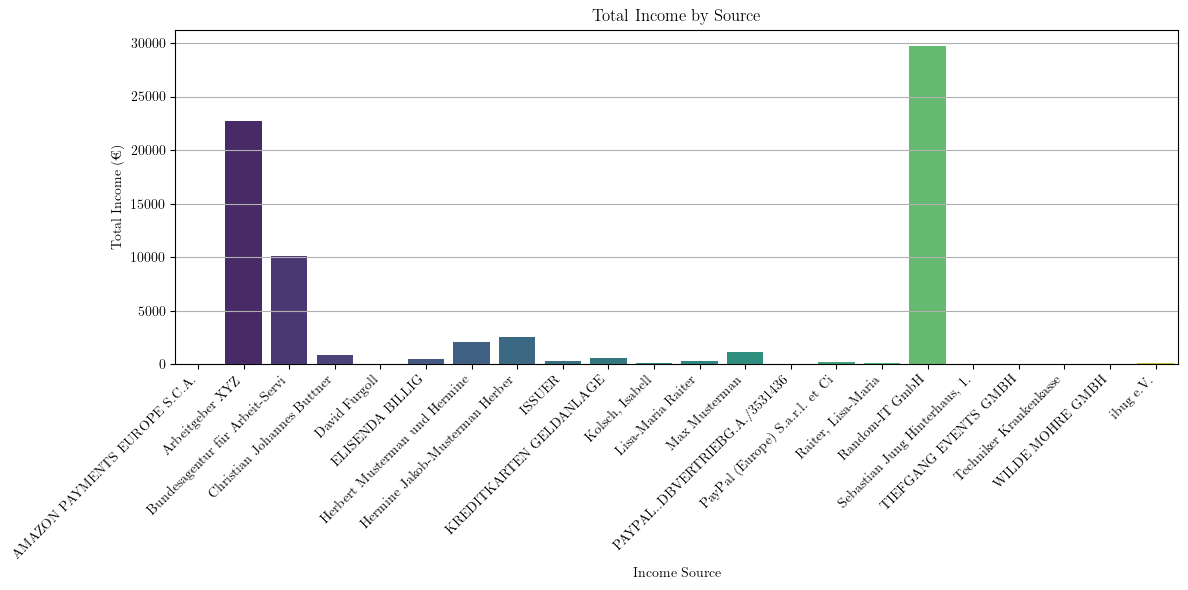

'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_by_source.png'

In [154]:
# Analyzes and visualizes income sources with bar plots
income_by_source(df, plots_path)

## E. 12 Income VS. Expenses

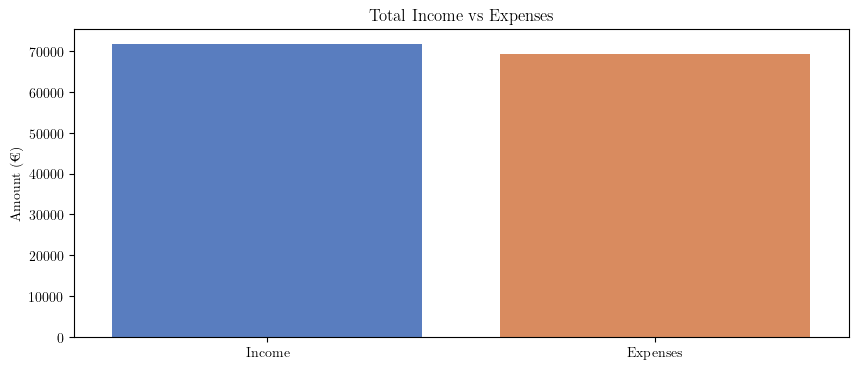

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_total_income_expenses.png'

In [155]:
# Plot total income vs expenses
plot_total_income_expenses(df, plots_path)

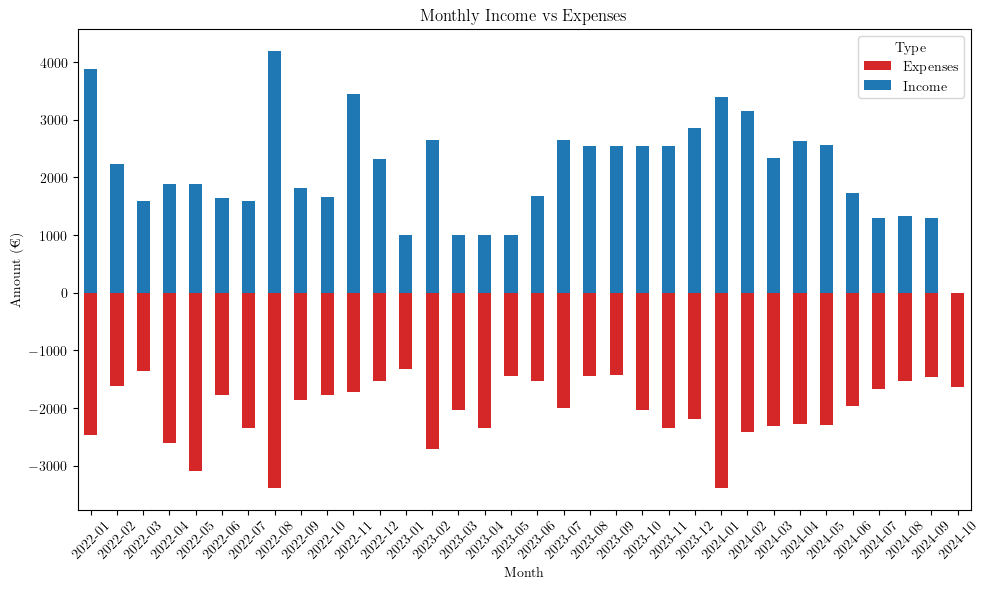

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_income_vs_expenses.png'

In [156]:
# Plot monthly income vs expenses
plot_monthly_income_vs_expenses(df, plots_path)

## E. 13 Savings and expanses distribution

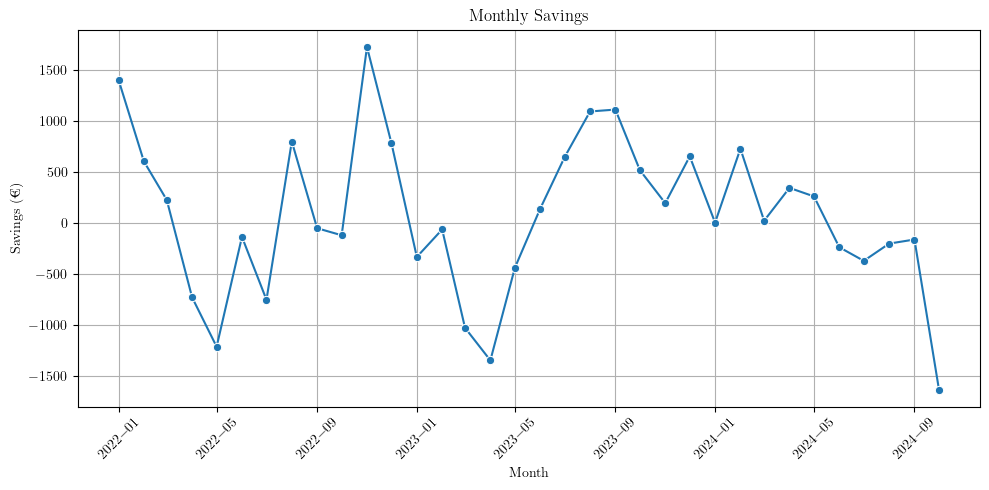

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_savings.png'

In [157]:
# Savings and expanses plot execution
plot_monthly_savings(df, plots_path)

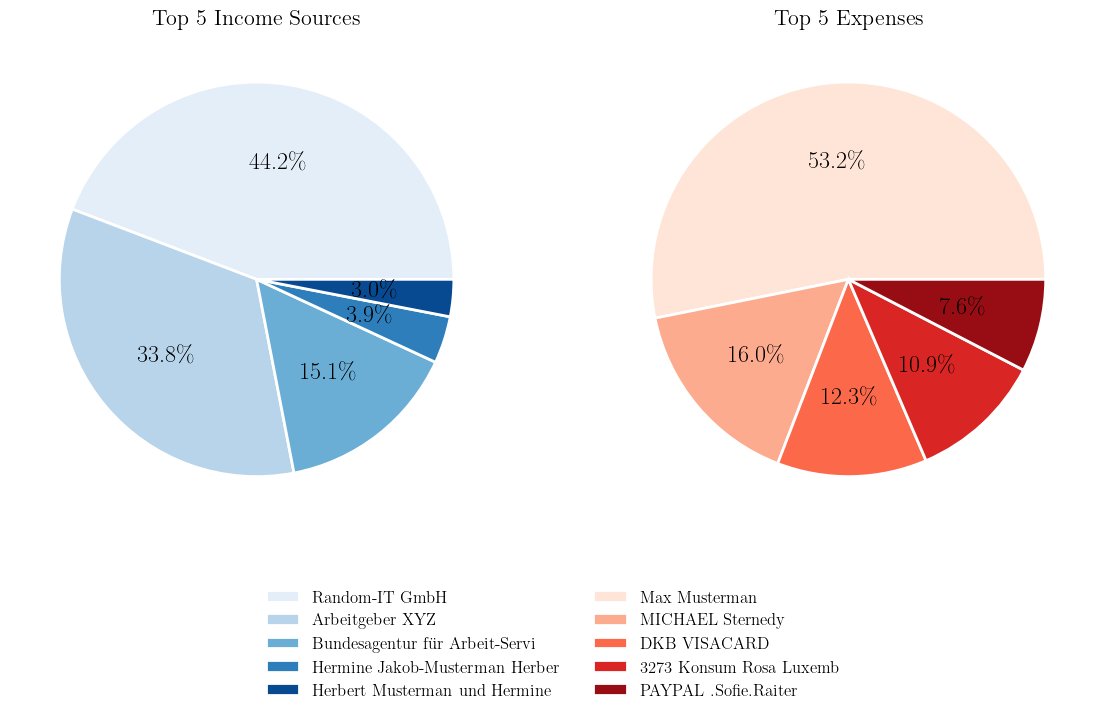

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_largest_expenses_income.png'

In [158]:
# Plot the larges income and expanses 
plot_largest_expenses_income(df, plots_path)

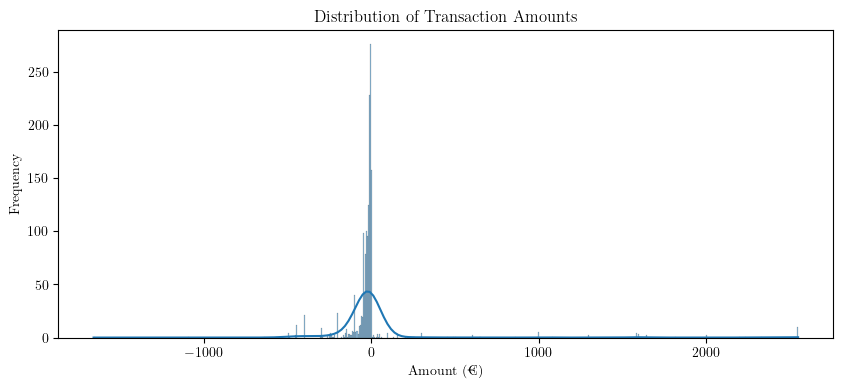

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_transaction_distribution.png'

In [159]:
# Plot distribution of transactions amounts
plot_transaction_distribution(df, plots_path)    

## E. 14 Category comparisson

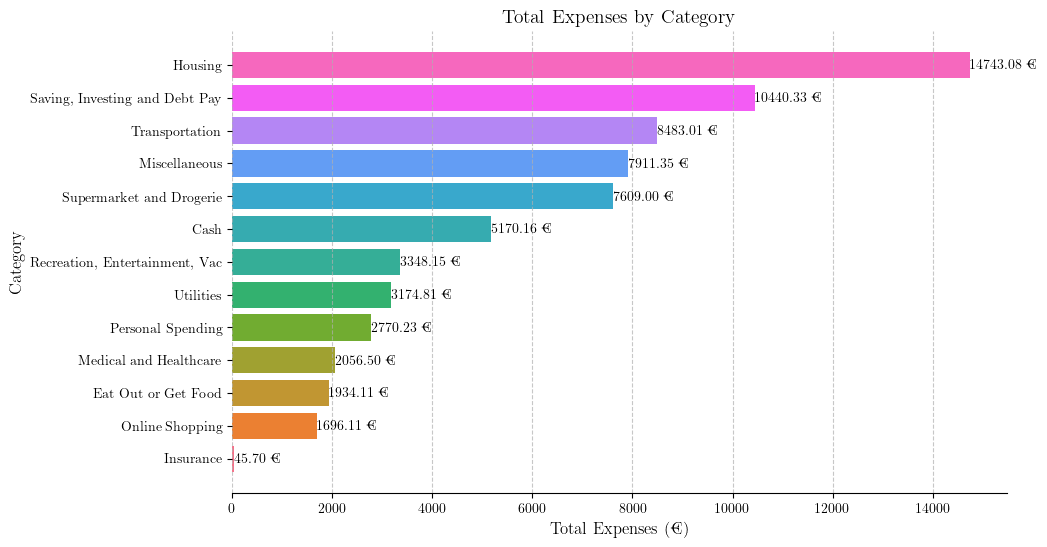

In [160]:
# Comparisson of expenses by category - absolut numbers 
saved_path = plot_expenses_barplot(df, plots_path)

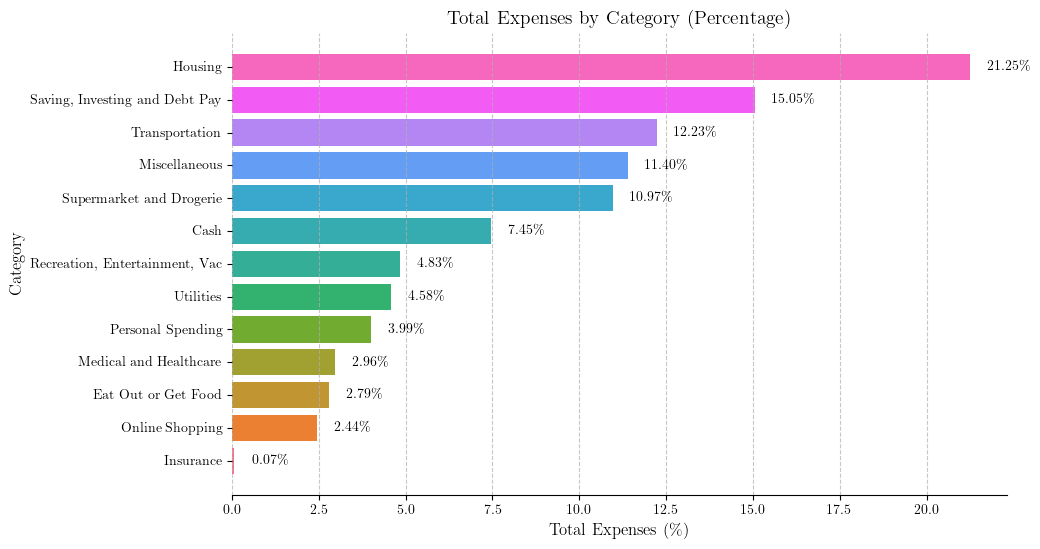

In [161]:
# Comparisson of expenses by category - relative
saved_path = plot_expenses_barplot_percent(df, plots_path)

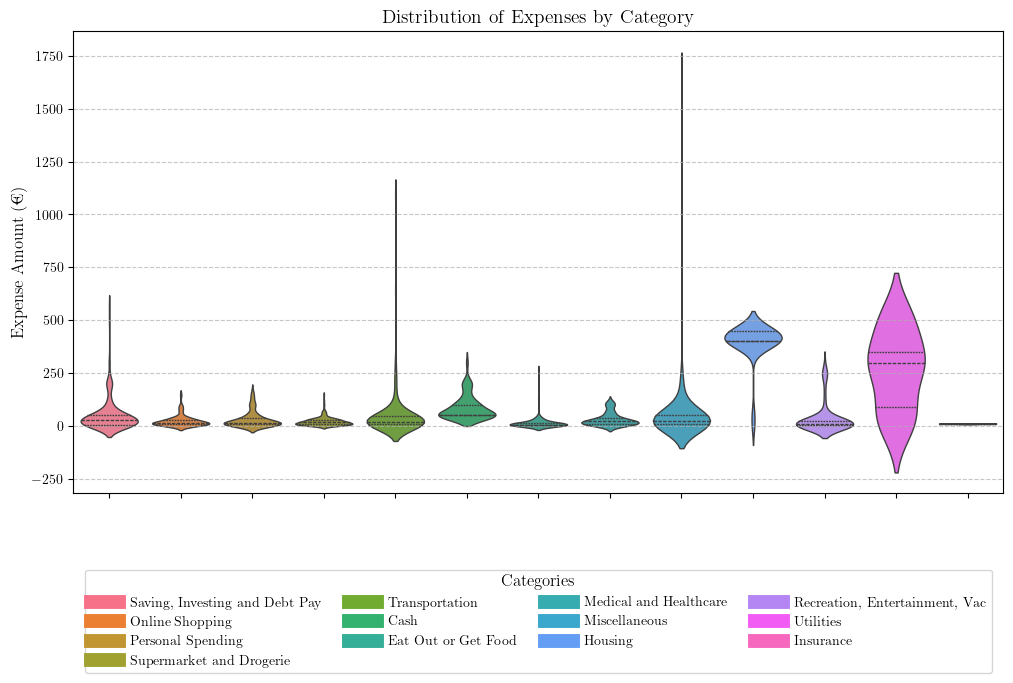

In [162]:
# Distribution of expenses by category in a violin plot
saved_path = plot_expenses_violin(df, plots_path)

# F. Writing all the text output and images into a pdf for an overview sheet
- iterating through all functions seen above 
- iterating through all the plots which are saved in the plots folder 
- write it all down in a pdf and save it in reports 

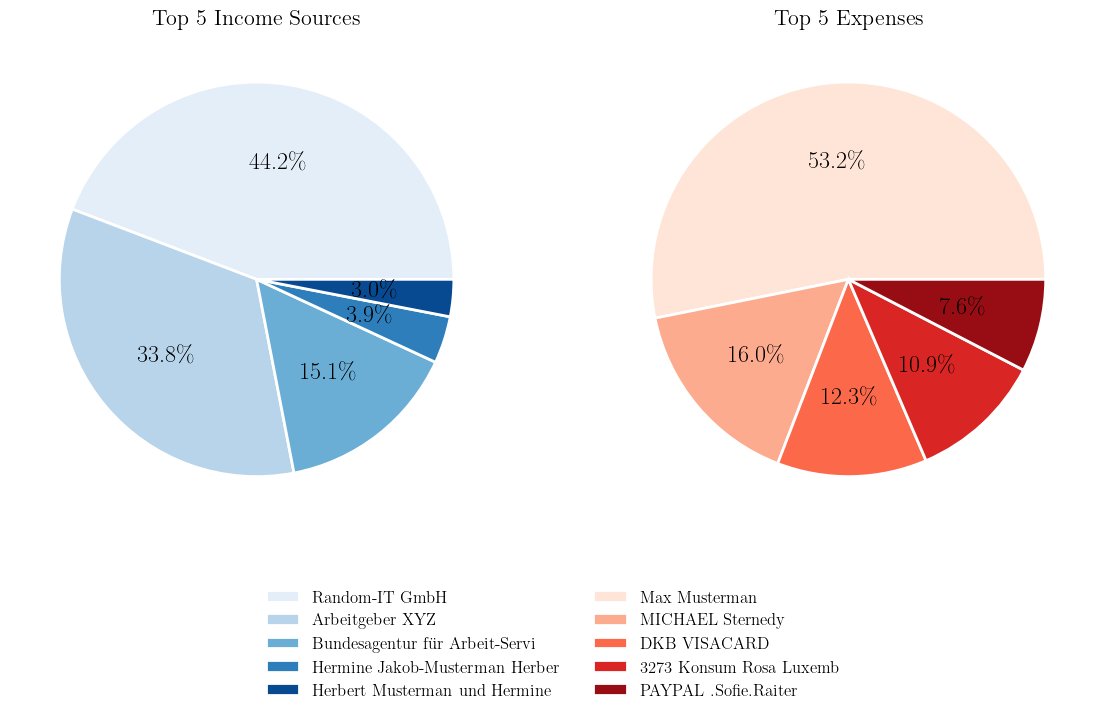

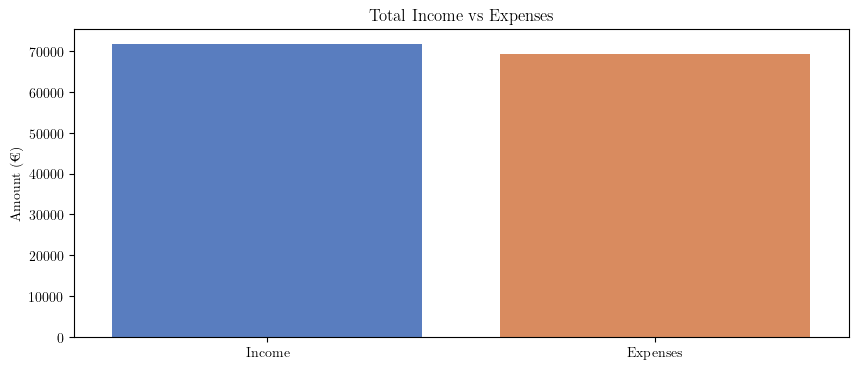

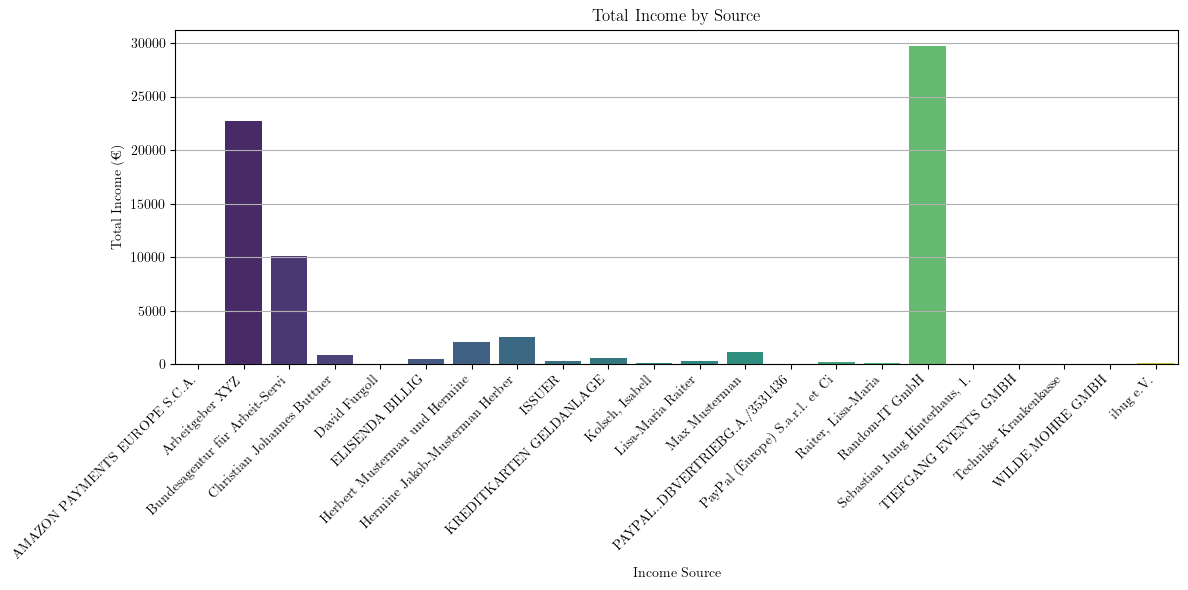

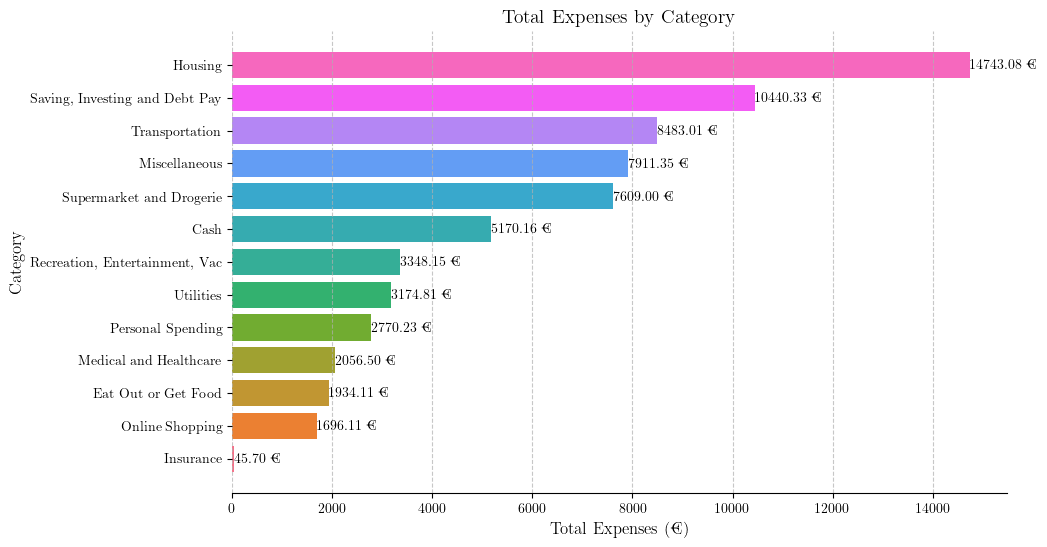

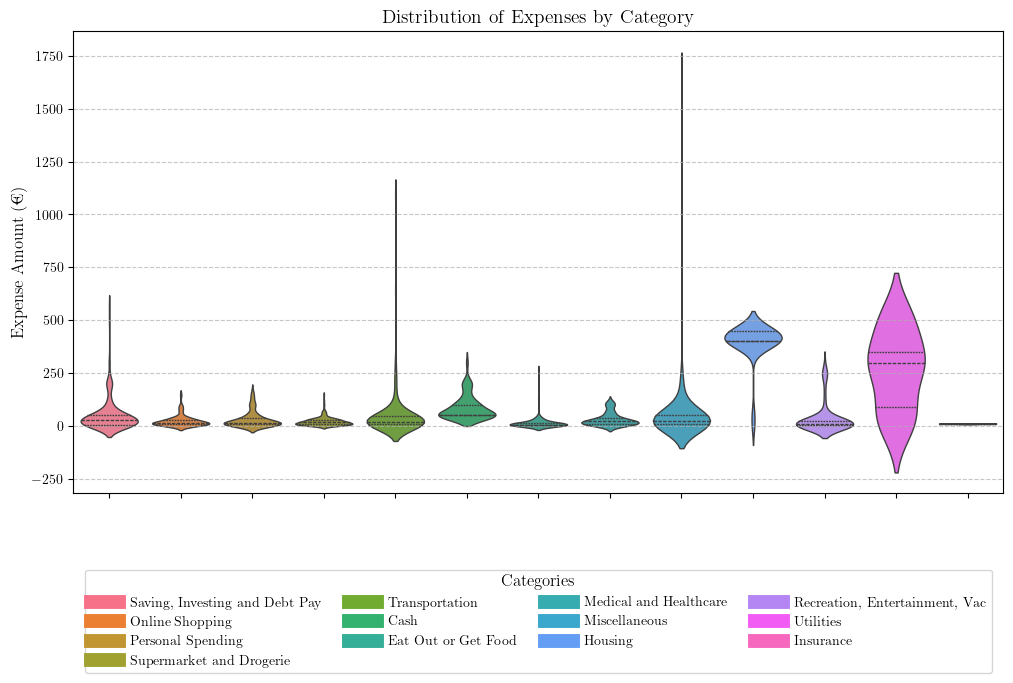

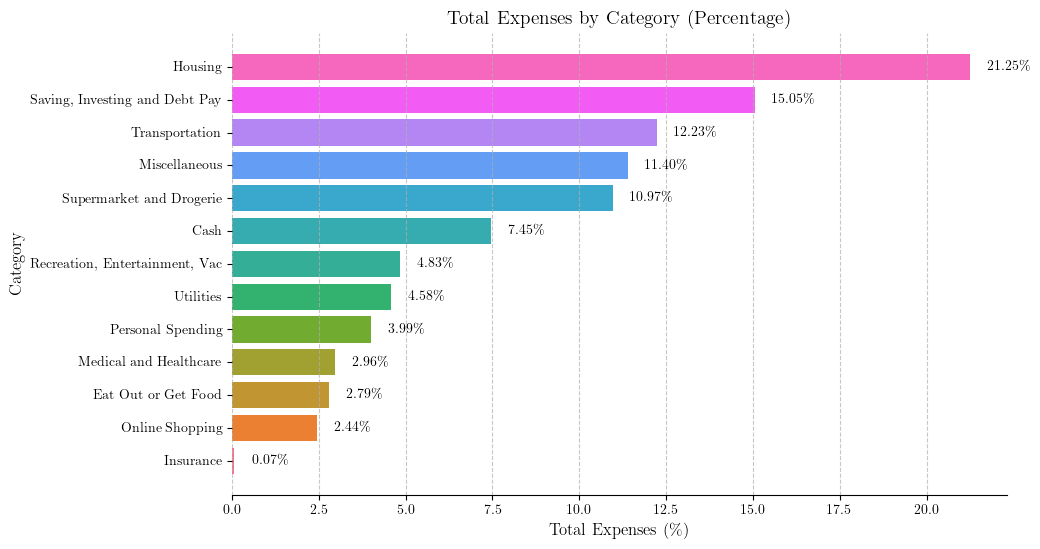

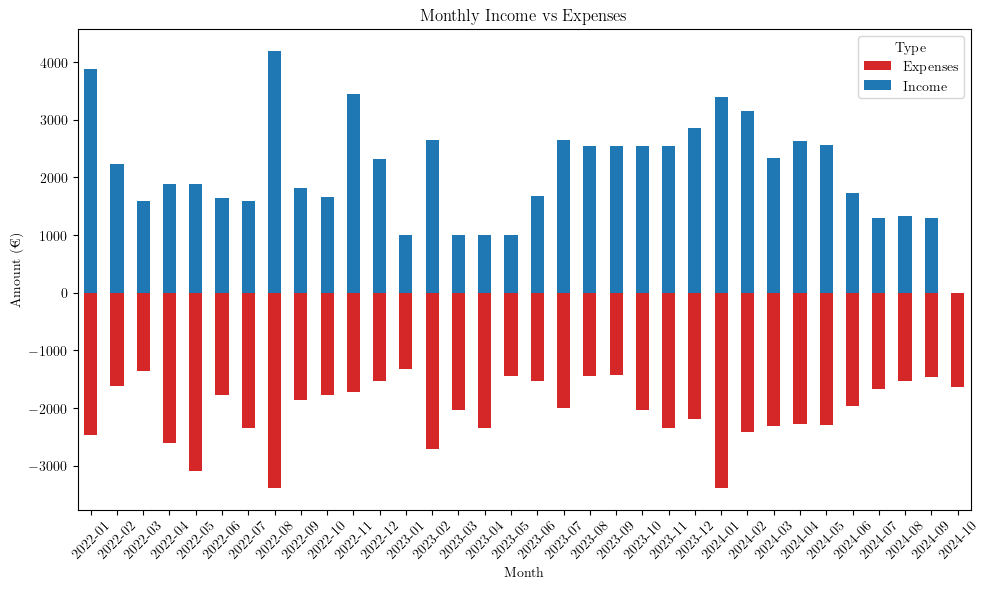

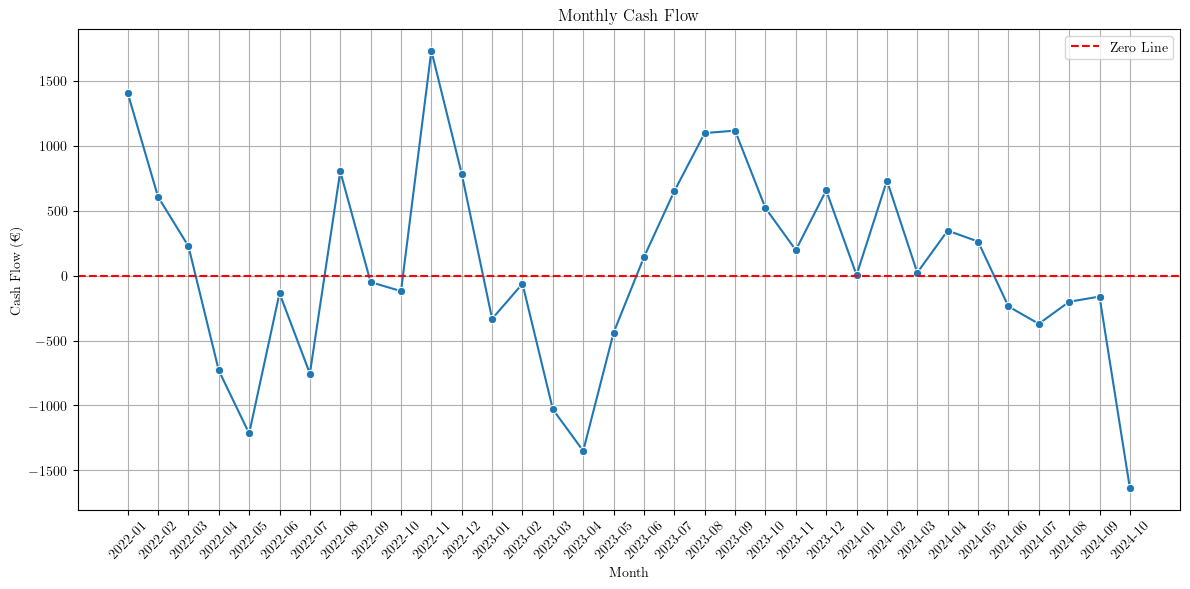

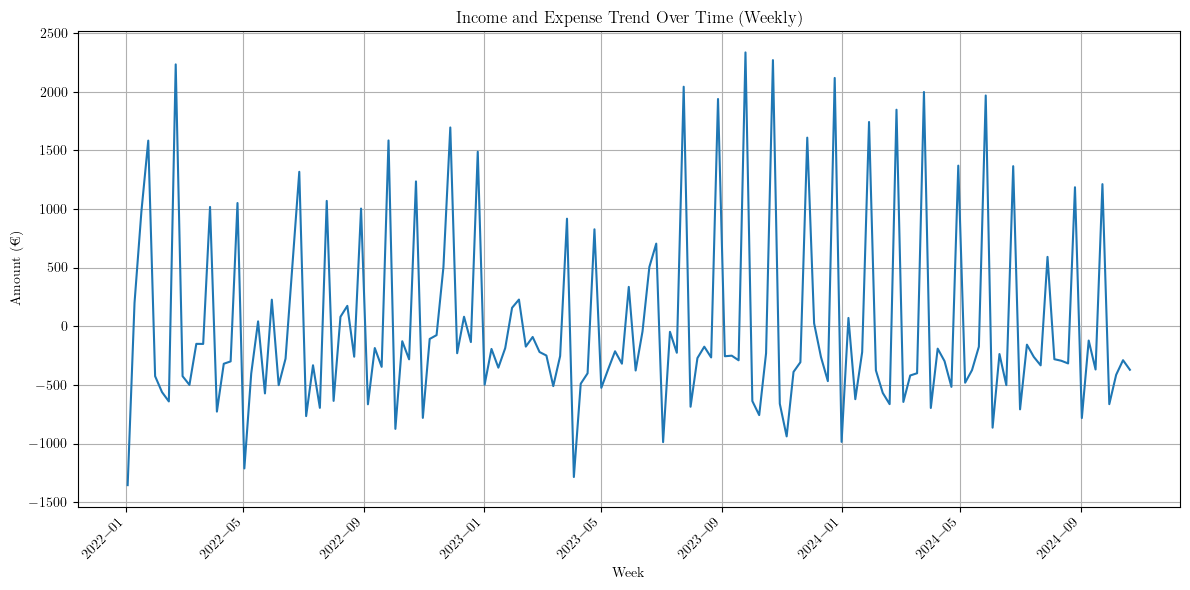

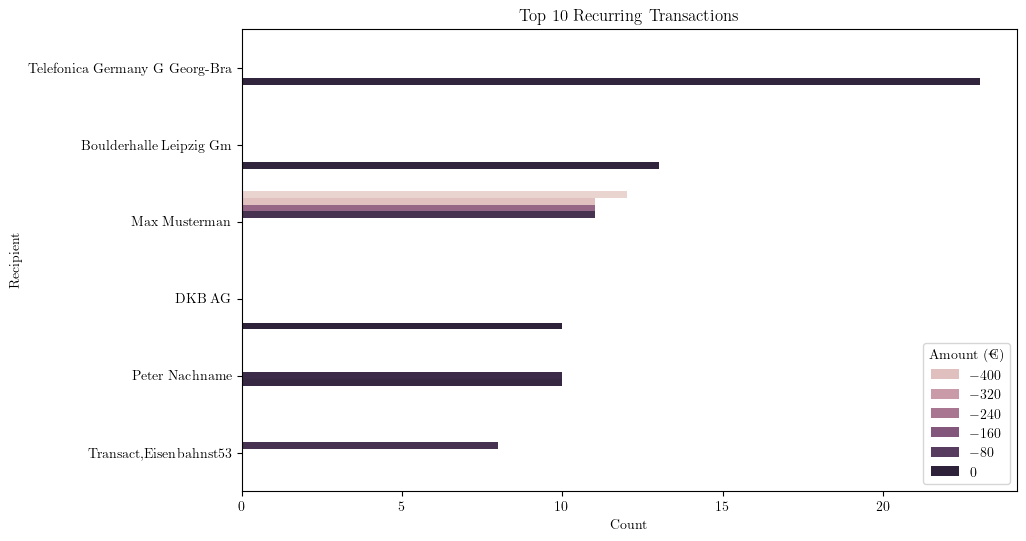

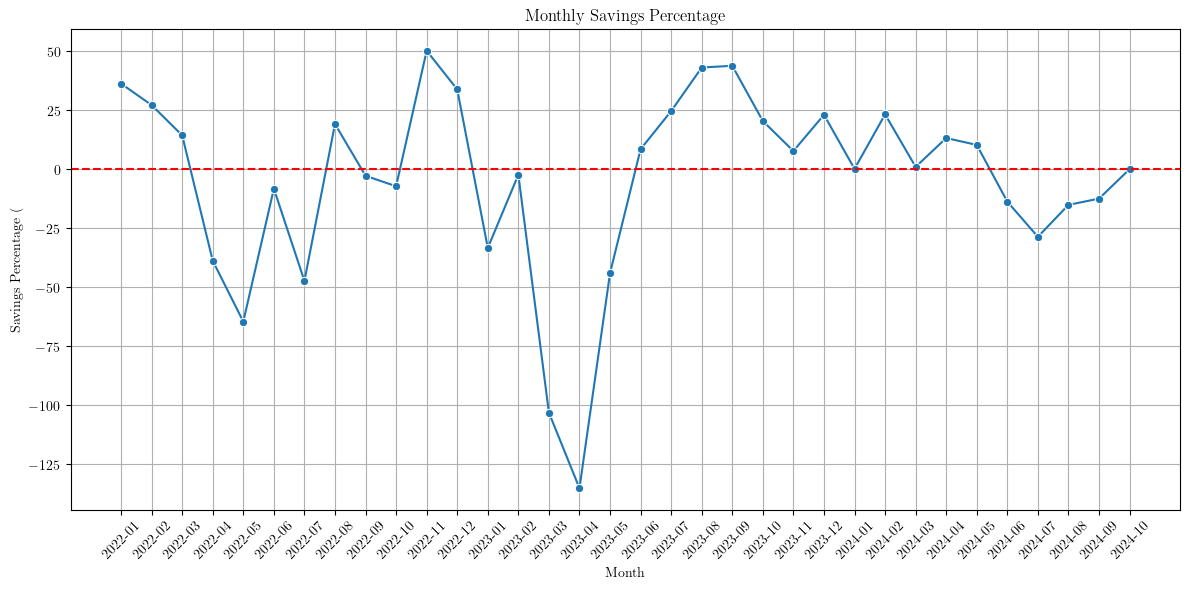

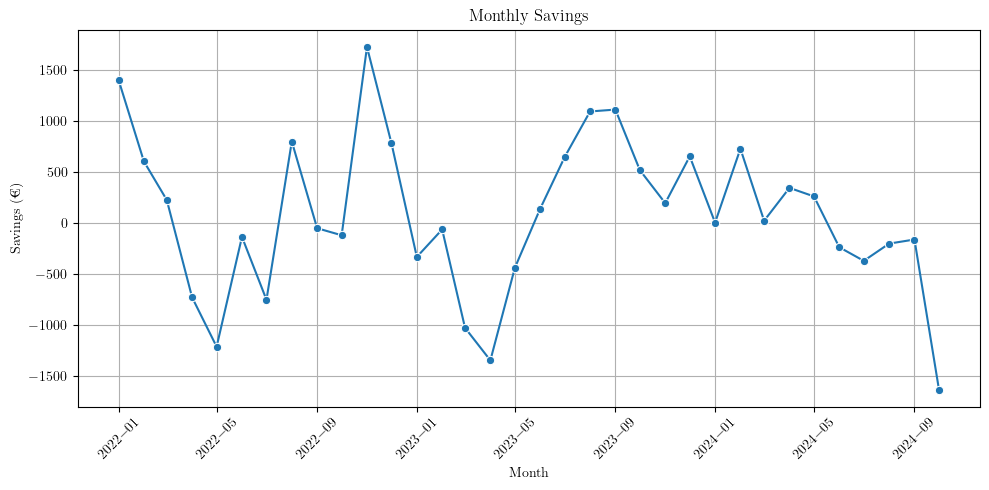

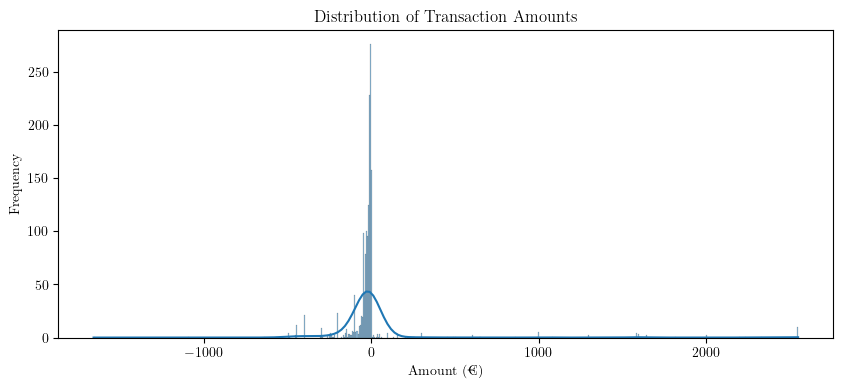

PDF saved to /Users/tillo/Repositoriums/FinanceGrouper/reports/financial_report.pdf


In [163]:
# Main programm for the pdf generation
# Separate functions will be called and the output (text and plots)
# will be placed in the summary pdf 
if __name__ == "__main__":
    plot_functions_1 = [
        ("Largest Expenses vs Income", lambda: plot_largest_expenses_income(df, plots_path)),
        ("Total Income vs Expenses", lambda: plot_total_income_expenses(df, plots_path)),
        ("Income by Source", lambda: income_by_source(df, plots_path)),
        ("Expenses Barplot", lambda: plot_expenses_barplot(df, plots_path)),
        ("Expenses Violin Plot", lambda: plot_expenses_violin(df, plots_path)),
        ("Expenses Barplot Percent", lambda: plot_expenses_barplot_percent(df, plots_path)),
        ("Monthly Income vs Expenses", lambda: plot_monthly_income_vs_expenses(df, plots_path)),

    ]
    text_functions_1 = [
        ("Basic Analysis", lambda: basic_analysis(df)),
        ("Average Monthly Stats", lambda: average_monthly_stats(df)),
        ("Analyze by Category", lambda: analyze_by_category(df)),
        ("Recurring Transactions Summary", lambda: text_recurring_transactions(recurring_summary)),
        #("Expense to Income Ratio", lambda: expense_income_ratio(df)),
    ]
    plot_functions_2 = [
        ("Cash Flow Volatility", lambda: cash_flow_volatility(df, plots_path)),
        ("Income Expense Trend", lambda: income_expense_trend(df, plots_path)),
        ("Recurring Summary", lambda: plot_recurring_summary(recurring_summary, plots_path)),
        ("Savings Percentage", lambda: savings_percentage(df, plots_path)),
        ("Monthly Savings", lambda: plot_monthly_savings(df, plots_path)),
        ("Transaction Distribution", lambda: plot_transaction_distribution(df, plots_path)),
    ]
    text_functions_2 = [
        #("Detect Outliers", lambda: detect_outliers(df)),
        #("Expenses by Recipient", lambda: expenses_by_recipient(df))
    ]    

    # Combine the functions from both sets
    plot_functions = plot_functions_1 + plot_functions_2
    text_functions = text_functions_1 + text_functions_2

    output_pdf_path = os.path.join(report_path, "financial_report.pdf")
    save_to_pdf(text_functions, plot_functions, output_pdf_path)


# G. Writing treated data frame to file 

In [164]:
# Save the treated and evaluated DataFrame to "Data_Treated.csv"
output_path = os.path.join(data_path, "Data_Treated.csv")
df.to_csv(output_path, index=False, sep=';')
print(f"Finalized DataFrame saved to: {output_path}")

Finalized DataFrame saved to: /Users/tillo/Repositoriums/FinanceGrouper/data/Data_Treated.csv
